In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.FeatExtModels_NoKaiser import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Data

In [2]:
DATA = np.load('./Data/AsanTRSet.npy')

#### Env setting

In [3]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
### Model checkpoint
ModelSaveSameName = save_path+'FeatGenM_ver2.1.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=500)

LatDim = 100
SigDim = DATA.shape[1]
MaskingRate = 0.02
NoiseStd = 0.002
MaskStd = 0.1
ReparaStd = 0.1

### Vae Loss; RecMSE and KL Divergence

In [7]:
EncModel = EncoderModel(SigDim=SigDim, Type = 'FX', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, training=False) 
FeExModel = FeatExtractModel()
DecModel = DecoderModel(SigDim=SigDim)
VaeSFModel = VaeModel(EncModel,FeExModel, DecModel )
VaeSFModel.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics={"Out":'mse'})

# apply beta and capacity
Capacity = 0.0# 0.1 0.05
Beta = 1.0 # 0.01

### Vae Loss; KL Divergence
Z_Sampled, Z_Log_Sigma = EncModel.get_layer('Z_Mean_FX').output,EncModel.get_layer('Z_Log_Sigma_FX').output
kl_Loss = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss = tf.reduce_mean(kl_Loss )
kl_Loss = Beta * tf.abs(kl_Loss - Capacity)


VaeSFModel.add_loss(kl_Loss )
VaeSFModel.add_metric(kl_Loss, 'KL_D')

VaeSFModel.summary()

Model: "VaeSFModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame_1 (TFOpLambda)  (None, 10, 100)      0           input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 10, 100)      45600       tf.signal.frame_1[0][0]          
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 40)           14640       bidirectional_4[0][0]            
_________________________________________________________________________________________

In [16]:
'''
VaeSFModel.load_weights(ModelSaveSameName)
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

VaeSFModel.fit(DATA[:], DATA[:], batch_size=3000, epochs=300, shuffle=True, validation_split=0.2, callbacks=[ModelSave, EarlyStop])
'''

"\nVaeSFModel.load_weights(ModelSaveSameName)\nModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )\n\nVaeSFModel.fit(DATA[:], DATA[:], batch_size=3000, epochs=300, shuffle=True, validation_split=0.2, callbacks=[ModelSave, EarlyStop])\n"

In [8]:
Sig_HH = FeExModel.get_layer('Sig_HH').output[:,:,0]
Sig_HL = FeExModel.get_layer('Sig_HL').output[:,:,0]
Sig_LH = FeExModel.get_layer('Sig_LH').output[:,:,0]
Sig_LL = FeExModel.get_layer('Sig_LL').output[:,:,0]

LatM = Model(FeExModel.input, tf.concat([Sig_HH, Sig_HL, Sig_LH, Sig_LL ], axis=1))

Pred_ZMean = Model(EncModel.input, EncModel.get_layer('Z_Mean_FX').output).predict(DATA[:], batch_size= 3000, verbose=1)
PredLat = LatM.predict([DATA[:],Pred_ZMean], batch_size= 3000, verbose=1 )

200/200 [==============================] - 43s 215ms/step


In [50]:
def Encoder():
    
    training = True
    Type = 'FG'
    LatDim = 2

    InpL = Input(shape=(SigDim,))
    InpFrame = tf.signal.frame(InpL, 100, 100)

    if training:
        InpRegul = GaussianNoise(stddev=NoiseStd)(InpFrame, training=training)
        MaskVec, NoisVec = MaskingGen(InpRegul, MaskingRate, MaskStd)
        EncInp = Masking(mask_value=0.)(InpRegul * MaskVec )
        EncOut = InpRegul + NoisVec
    else:
        EncInp, EncOut = InpFrame, InpFrame

    Encoder = Dense(40, activation='softplus')(InpFrame)
    Encoder = Bidirectional(GRU(30, return_sequences=True))(Encoder)
    Encoder = Bidirectional(GRU(20, return_sequences=False))(Encoder)
    Encoder = Dense(50, activation='softplus')(Encoder)
    Encoder = Dense(30, activation='softplus')(Encoder)
    Encoder = Dense(15, activation='softplus')(Encoder)

    Z_Mean_ft = Dense(LatDim, activation='linear')(Encoder)
    Z_Log_Sigma_ft = Dense(LatDim, activation='softplus')(Encoder)
    Z_Log_Sigma_ft = ReName(Z_Log_Sigma_ft,'Z_Log_Sigma_'+Type)

    # Reparameterization Trick for sampling 
    Epsilon = tf.random.normal(shape=(tf.shape(Z_Mean_ft)[0], Z_Mean_ft.shape[1]), mean=0., stddev=ReparaStd)

    if training==False:
        Epsilon = Epsilon * 0

    Z_Mean_ft = Z_Mean_ft + tf.exp(0.5 * Z_Log_Sigma_ft) * Epsilon
    Z_Mean_ft = ReName(Z_Mean_ft,'Z_Mean_'+Type)

    return [InpL], [Z_Mean_ft]


def Decoder (Z_Inp):
   
    Dec_Sig_HH = Dense(15, activation='softplus')(Z_Inp)
    Dec_Sig_HH = Dense(30, activation='softplus')(Dec_Sig_HH)
    Dec_Sig_HH = Dense(50, activation='softplus')(Dec_Sig_HH)

    Dec_Sig_HH = RepeatVector(10 )(Dec_Sig_HH)
    Dec_Sig_HH = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_HH)
    Dec_Sig_HH = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_HH)
    Dec_Sig_HH = Dense(40,'tanh')(Dec_Sig_HH)
    Sig_HH= Flatten(name='Sig_HH')(Dec_Sig_HH)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_HL = Dense(15, activation='softplus')(Z_Inp)
    Dec_Sig_HL = Dense(30, activation='softplus')(Dec_Sig_HL)
    Dec_Sig_HL = Dense(50, activation='softplus')(Dec_Sig_HL)

    Dec_Sig_HL = RepeatVector(10 )(Dec_Sig_HL)
    Dec_Sig_HL = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_HL)
    Dec_Sig_HL = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_HL)
    Dec_Sig_HL = Dense(40,'tanh')(Dec_Sig_HL)
    Sig_HL= Flatten(name='Sig_HL')(Dec_Sig_HL)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_LH = Dense(15, activation='softplus')(Z_Inp)
    Dec_Sig_LH = Dense(30, activation='softplus')(Dec_Sig_LH)
    Dec_Sig_LH = Dense(50, activation='softplus')(Dec_Sig_LH)

    Dec_Sig_LH = RepeatVector(10 )(Dec_Sig_LH)
    Dec_Sig_LH = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_LH)
    Dec_Sig_LH = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_LH)
    Dec_Sig_LH = Dense(40,'tanh')(Dec_Sig_LH)
    Sig_LH= Flatten(name='Sig_LH')(Dec_Sig_LH)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_LL = Dense(15, activation='softplus')(Z_Inp)
    Dec_Sig_LL = Dense(30, activation='softplus')(Dec_Sig_LL)
    Dec_Sig_LL = Dense(50, activation='softplus')(Dec_Sig_LL)

    Dec_Sig_LL = RepeatVector(10 )(Dec_Sig_LL)
    Dec_Sig_LL = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_LL)
    Dec_Sig_LL = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_LL)
    Dec_Sig_LL = Dense(40,'tanh')(Dec_Sig_LL)
    Sig_LL= Flatten(name='Sig_LL')(Dec_Sig_LL)
    
    return  tf.concat([Sig_HH, Sig_HL, Sig_LH, Sig_LL], axis=-1)


In [53]:
ModelInp, Z_Mean_ft = Encoder()
LatGenOut = Decoder(Z_Mean_ft[0])
LatGenOut = ReName(LatGenOut, 'Out')
SigGenModel = Model(ModelInp[0], LatGenOut)


def RECMSE (y_true, y_pred):
    
    RecMSE = tf.losses.mse(y_true, y_pred)
    RecMSE *= tf.cast(tf.shape(y_true)[-1], dtype=tf.float32)
    
    return RecMSE

SigGenModel.compile(loss=RECMSE, optimizer='adam', metrics={"Out":'mse'}) 


# apply beta and capacity
Capacity = 0.05 # 0.1 0.05
Beta = 0.1 # 0.01

### Vae Loss; KL Divergence
Z_Sampled, Z_Log_Sigma = SigGenModel.get_layer('Z_Mean_FG').output, SigGenModel.get_layer('Z_Log_Sigma_FG').output
kl_Loss = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss = tf.reduce_mean(kl_Loss )
kl_Loss = Beta * tf.abs(kl_Loss - Capacity)

SigGenModel.add_loss(kl_Loss )
SigGenModel.add_metric(kl_Loss, 'KL_D')



In [ ]:
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

SigGenModel.fit(DATA[:, :], PredLat[:, :], batch_size=3000, epochs=1000, shuffle=True, validation_split=0.2, callbacks=[ModelSave, EarlyStop])

Epoch 1/1000
107/107 [==============================] - 24s 122ms/step - loss: 14.3243 - mse: 0.0089 - KL_D: 0.1048 - val_loss: 6.3738 - val_mse: 0.0040 - val_KL_D: 1.7510e-05

Epoch 00001: val_mse improved from inf to 0.00398, saving model to ./Results\FeatGenM_ver2.1.hdf5
Epoch 2/1000
107/107 [==============================] - 9s 82ms/step - loss: 5.3344 - mse: 0.0033 - KL_D: 0.0247 - val_loss: 4.2528 - val_mse: 0.0026 - val_KL_D: 0.0270

Epoch 00002: val_mse improved from 0.00398 to 0.00264, saving model to ./Results\FeatGenM_ver2.1.hdf5
Epoch 3/1000
107/107 [==============================] - 9s 80ms/step - loss: 4.0671 - mse: 0.0025 - KL_D: 0.0243 - val_loss: 3.9859 - val_mse: 0.0025 - val_KL_D: 0.0231

Epoch 00003: val_mse improved from 0.00264 to 0.00248, saving model to ./Results\FeatGenM_ver2.1.hdf5
Epoch 4/1000
107/107 [==============================] - 8s 79ms/step - loss: 3.9434 - mse: 0.0024 - KL_D: 0.0237 - val_loss: 3.9300 - val_mse: 0.0024 - val_KL_D: 0.0241

Epoch 00004

In [27]:
### Define total model again
ModelInp, Z_Mean_ft = Encoder()
LatGenOut = Decoder(Z_Mean_ft[0])
LatGenOut = ReName(LatGenOut, 'Out')
SigGenModel = Model(ModelInp[0], LatGenOut)

### Load trained layers
EncoderLayers = Model(ModelInp, Z_Mean_ft).layers
DecoderStartIDX = len(EncoderLayers)
DecoderLayers = SigGenModel.layers[DecoderStartIDX:]


### Define a sub-model
New_DecInp = Input((2,))
New_DecOut = Decoder(New_DecInp)
New_DecModel = Model(New_DecInp, New_DecOut)

### Weight update
DecoderLayersWeights = []
for i in DecoderLayers:
    DecoderLayersWeights.extend(i.get_weights())
    
New_DecModel.set_weights(DecoderLayersWeights)

In [35]:
Pred = SigGenModel.predict(DATA[:, :], batch_size=3000, verbose=1)

134/134 [==============================] - 4s 18ms/step


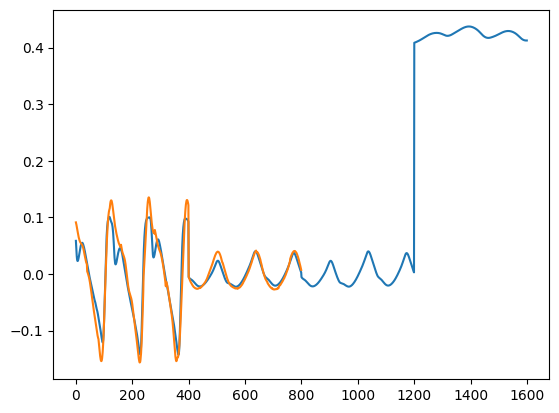

In [49]:
idx = 6974
plt.plot(PredLat[idx])
plt.plot(Pred[idx])